In [1]:
#  Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

warnings.filterwarnings("ignore")
sns.set(style='whitegrid', palette='muted')

In [2]:
#  Load and explore data
data = pd.read_csv("breast-cancer.csv")
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
data.drop(['id', 'Unnamed: 32'], axis=1, inplace=True, errors='ignore')

In [4]:
print("Initial data shape:", data.shape)

Initial data shape: (569, 31)


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

In [6]:
print("Missing values:\n", data.isnull().sum())

Missing values:
 diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


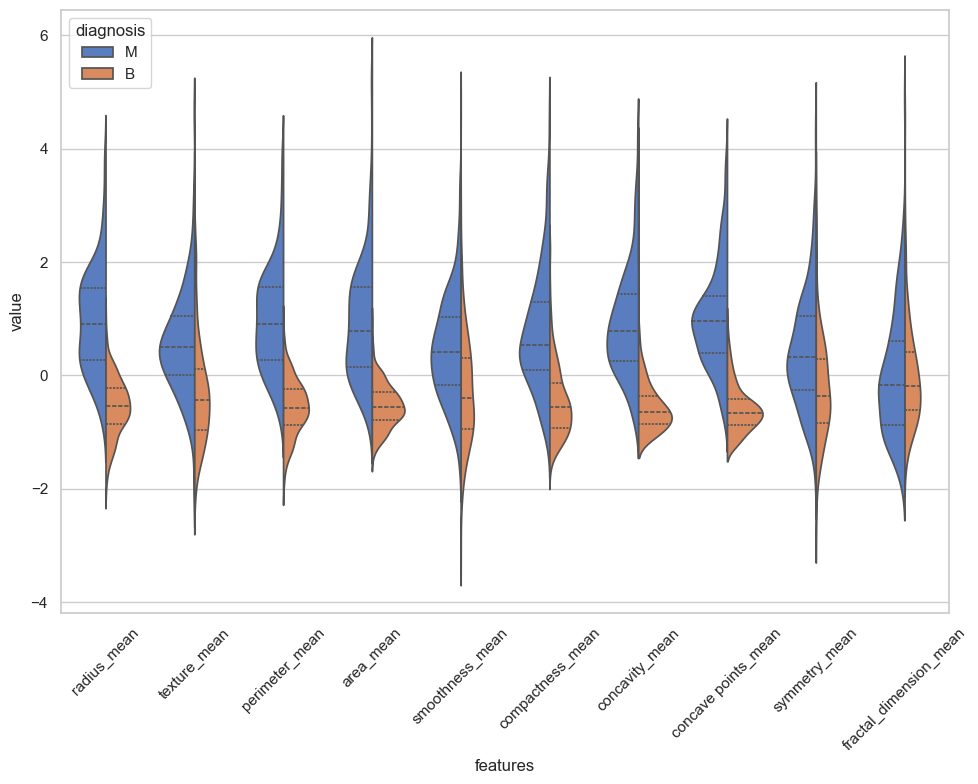

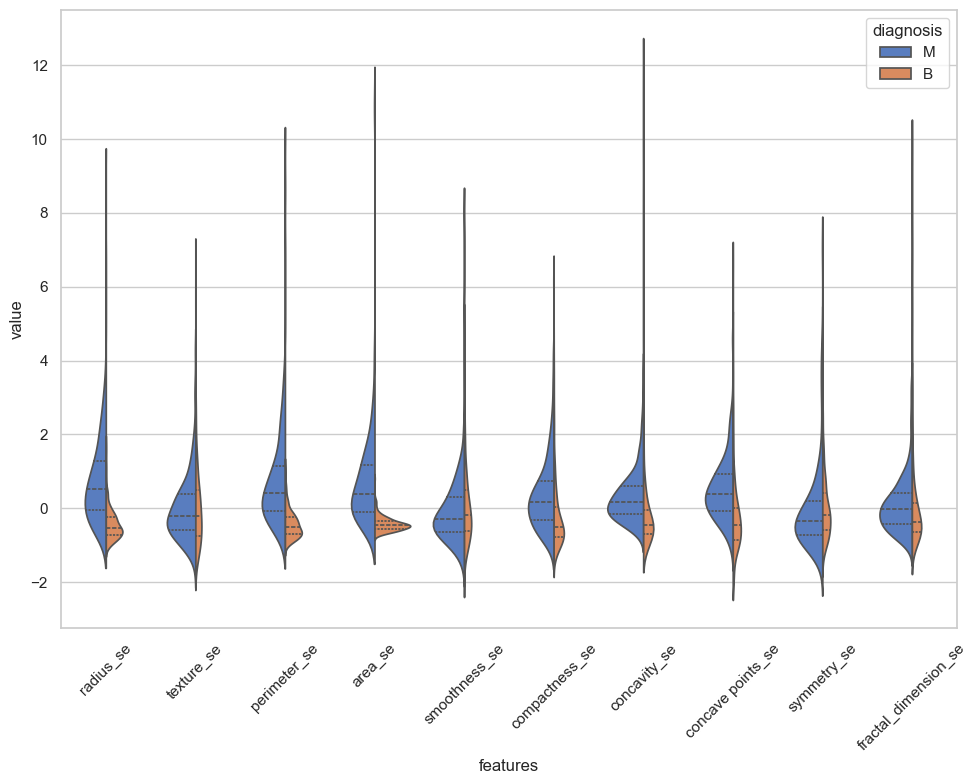

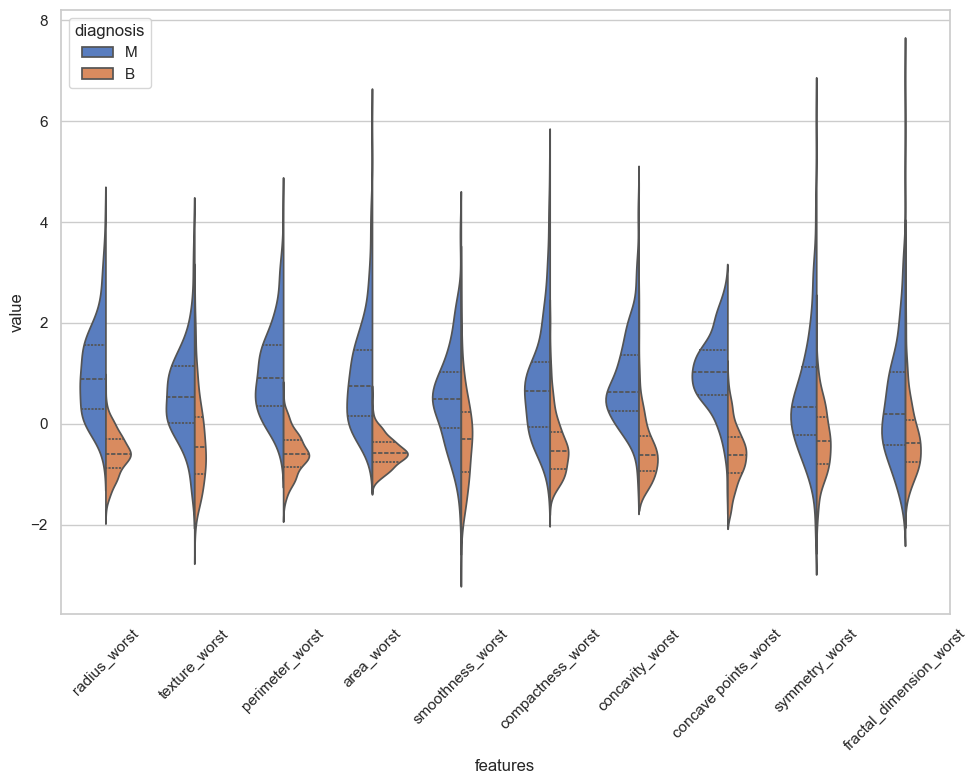

In [7]:
#  Exploratory Data Analysis (EDA)
def violinplot_visualisation(start_index, end_index):
    df = data.drop('diagnosis', axis=1)
    df_std = (df - df.mean()) / df.std()
    df = pd.concat([data['diagnosis'], df_std.iloc[:, start_index:end_index]], axis=1)
    df = pd.melt(df, id_vars='diagnosis', var_name='features', value_name='value')
    plt.figure(figsize=(10, 8))
    sns.violinplot(x='features', y='value', hue='diagnosis', data=df, split=True, inner='quart')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

violinplot_visualisation(0, 10)
violinplot_visualisation(10, 20)
violinplot_visualisation(20, 30)

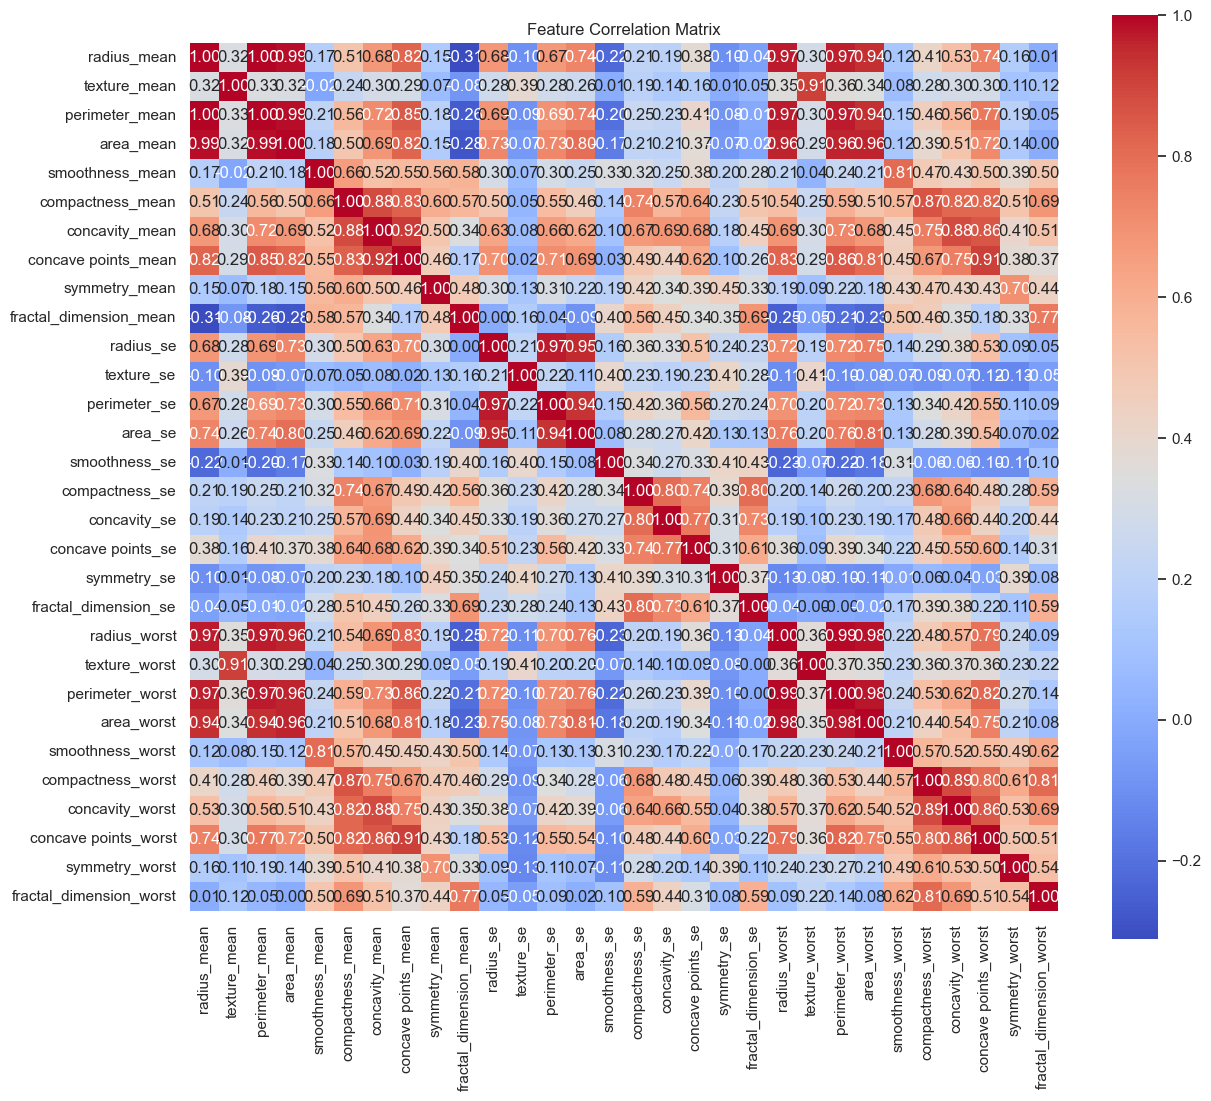

In [8]:
#  Correlation Matrix
corr = data.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Feature Correlation Matrix')
plt.show()

In [9]:
# Drop highly correlated features
drop_cols = ['perimeter_mean', 'area_mean', 'perimeter_se', 'area_se', 'radius_worst', 'perimeter_worst', 'area_worst']
data.drop(drop_cols, axis=1, inplace=True, errors='ignore')
print("Remaining features:", data.columns.tolist())

Remaining features: ['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'texture_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


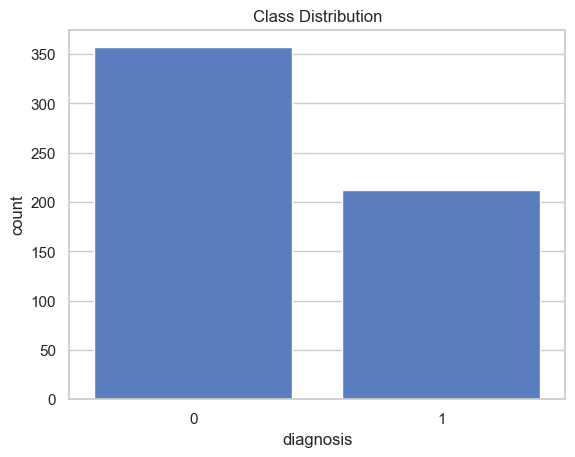

In [10]:
#  Encode labels
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})
sns.countplot(x='diagnosis', data=data)
plt.title("Class Distribution")
plt.show()

In [11]:
#  Feature and label split
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values    

In [12]:
#  Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101, stratify=y)

In [13]:
#  Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

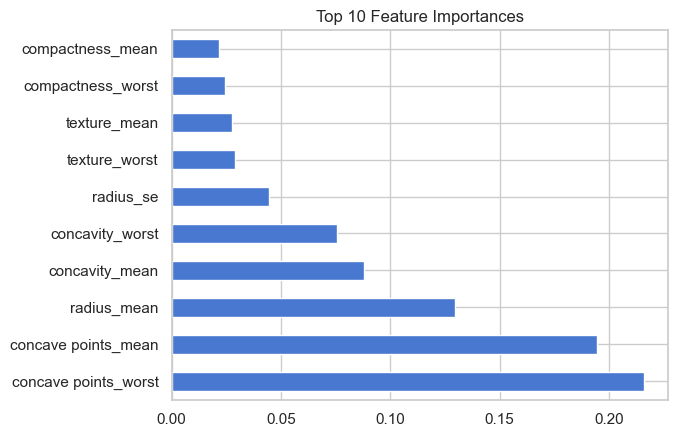

In [14]:
#  Feature Importance with RandomForest
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)
feat_importances = pd.Series(rf.feature_importances_, index=data.drop('diagnosis', axis=1).columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

In [15]:
#  Deep Learning Model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
#  Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5)
]

In [17]:
# Train Model
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=64,
    epochs=11,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7789 - loss: 0.6188 - val_accuracy: 0.8741 - val_loss: 0.5121 - learning_rate: 0.0010
Epoch 2/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9056 - loss: 0.4678 - val_accuracy: 0.9091 - val_loss: 0.3932 - learning_rate: 0.0010
Epoch 3/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9238 - loss: 0.3612 - val_accuracy: 0.9161 - val_loss: 0.3028 - learning_rate: 0.0010
Epoch 4/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9374 - loss: 0.2702 - val_accuracy: 0.9301 - val_loss: 0.2386 - learning_rate: 0.0010
Epoch 5/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9256 - loss: 0.2193 - val_accuracy: 0.9371 - val_loss: 0.1985 - learning_rate: 0.0010
Epoch 6/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9613 - loss: 0.1524 - val_accuracy: 0.9441 - val_loss: 0.1733 - learning_rate: 0.0010
Epoch 7/11
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9526 - loss: 0.1405 - val_accuracy: 0.9371 - val

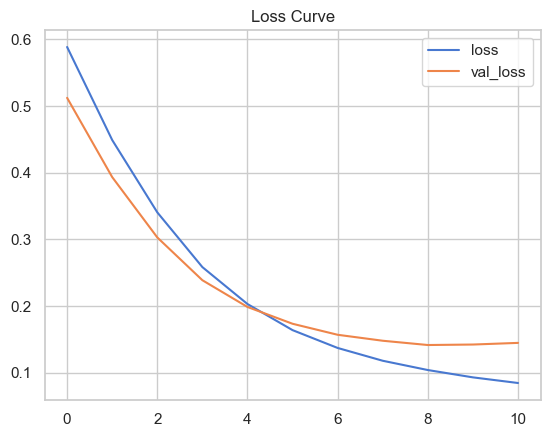

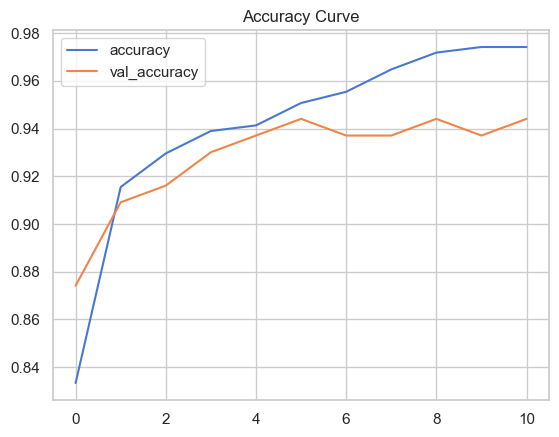

In [18]:
# Plot training curves
loss_df = pd.DataFrame(history.history)
loss_df[['loss', 'val_loss']].plot()
plt.title("Loss Curve")
plt.show()

loss_df[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy Curve")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        90
           1       0.92      0.92      0.92        53

    accuracy                           0.94       143
   macro avg       0.94      0.94      0.94       143
weighted avg       0.94      0.94      0.94       143



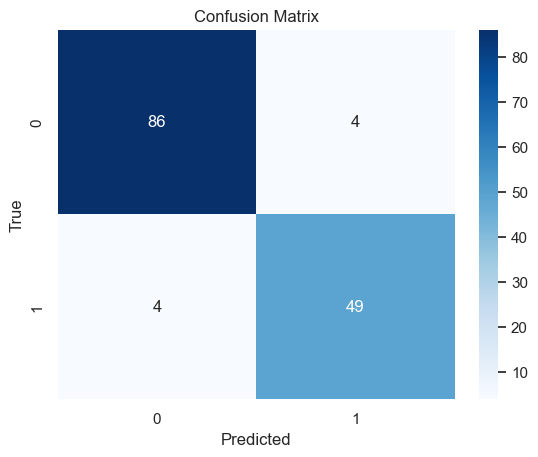

In [19]:
#  Evaluation
predictions = model.predict(X_test_scaled).round()
print("\nClassification Report:\n", classification_report(y_test, predictions))
conf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


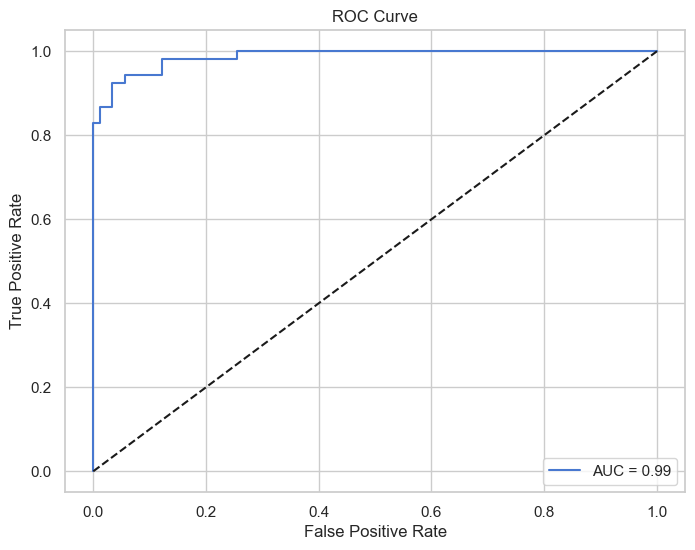

In [20]:
#  ROC Curve
y_pred_prob = model.predict(X_test_scaled).ravel()
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [21]:
# #  Save model
# model.save("breast_cancer_model.h5")
# print(" Model saved as 'breast_cancer_model.h5'")